<a href="https://colab.research.google.com/github/primuuzz/object_detection_demo/blob/master/Deteksi_helm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Menghubungkan ke Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Menyimpan hasil ekstrak ke dalam folder datasets
import zipfile,os
local_zip = "/content/drive/My Drive/dataset.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/datasets")
zip_ref.close()

Mengimpor Libraries yang digunakan

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from skimage.io import imread
from skimage.transform import resize
import statsmodels.api
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


time: 136 µs


In [ ]:
print(tf.__version__)

2.3.0
time: 837 µs


Preprocessing Datasets

Membuat Objek ImageDataGenertor dan Data Augmentation

Membuat obyek gambar dataset dengan ImageDataGenerator, augmentasi dataset dan membagi dataset validasi sebesar 20% dan dataset pelatihan sebesar 80%

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,    
    vertical_flip = True,
    fill_mode = "nearest")

time: 1.96 ms


Menggunakan Obyek Image Data Generator

In [ ]:
#Memuat dataset pelatihan & validasi
base_dir = os.path.join("/content/datasets/dataset/train")

img_size = 224
batch_size = 128

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['ga pake helm',
          'helm']

for i,label in enumerate(labels):
    folder = os.path.join("/content/datasets/dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 462 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 2)
Bentuk array dari dataset validation (validasi) adalah: (114, 224, 224, 3) (114, 2)
Bentuk array dari dataset test (pengujian) adalah: (63, 224, 224, 3) (63,)
time: 4.18 s


Menyimpan Label Datasets

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'ga pake helm': 0, 'helm': 1}
time: 1.78 ms


In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

time: 34.6 ms


Membuat model dari jaringan CNN yang sudah dipelajari sebelumnya (pre-trained covnets)

In [ ]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model 
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

17227776/17225924 [==============================] - 0s 0us/step
time: 6.42 s


Feature Extraction

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

time: 4.09 ms


Mempersiapkan Data Masukkan Pengujian

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

time: 1.86 ms


Pembuatan Model (Menambah Model)

In [ ]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(2, activation='softmax')

])


model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 6, 64)          262208    
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 3,491,202
Trainable params: 262,338
Non-trainable params: 3,228,864
_________________________________________________________________
time: 173 ms


Melatih model

In [ ]:
#es = EarlyStopping(monitor="val_loss", patience=7, verbose=1, min_delta=0.09, mode="auto")
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=val_generator)

Epoch 1/50
4/4 [==============================] - 6s 2s/step - loss: 1.7425 - acc: 0.8268 - val_loss: 0.7181 - val_acc: 0.8684
Epoch 2/50
4/4 [==============================] - 5s 1s/step - loss: 0.4647 - acc: 0.8723 - val_loss: 0.4377 - val_acc: 0.9211
Epoch 3/50
4/4 [==============================] - 5s 1s/step - loss: 0.4617 - acc: 0.9026 - val_loss: 0.3831 - val_acc: 0.9561
Epoch 4/50
4/4 [==============================] - 5s 1s/step - loss: 0.3176 - acc: 0.9026 - val_loss: 0.1753 - val_acc: 0.8772
Epoch 5/50
4/4 [==============================] - 5s 1s/step - loss: 0.2064 - acc: 0.8961 - val_loss: 0.2432 - val_acc: 0.8947
Epoch 6/50
4/4 [==============================] - 5s 1s/step - loss: 0.1695 - acc: 0.9242 - val_loss: 0.0594 - val_acc: 0.9737
Epoch 7/50
4/4 [==============================] - 5s 1s/step - loss: 0.1207 - acc: 0.9502 - val_loss: 0.1219 - val_acc: 0.9474
Epoch 8/50
4/4 [==============================] - 5s 1s/step - loss: 0.1124 - acc: 0.9545 - val_loss: 0.1084 - 

Menampilkan Grafik Model Hasil Pelatihan

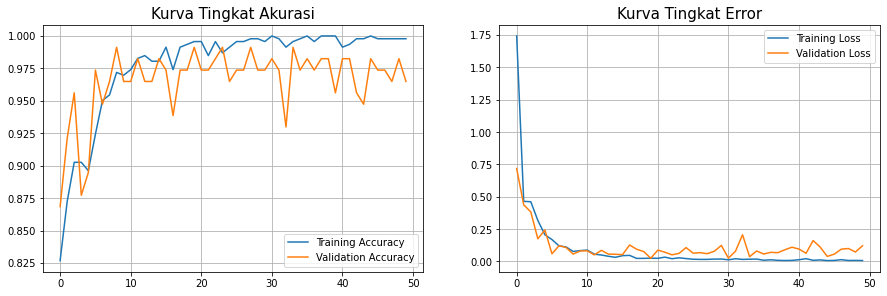

time: 280 ms


In [ ]:
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(history.history["acc"], label = "Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder=0)

plt.subplot(2, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder=0)
plt.show()

Menggunakan Model

In [ ]:
print(train_generator)

time: 759 µs


Evaluasi

In [ ]:
y_test2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

time: 3.46 ms


In [ ]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
time: 856 ms


Membuat Confusion Matrix

Normalized confusion matrix
[[0.92 0.08]
 [0.   1.  ]]


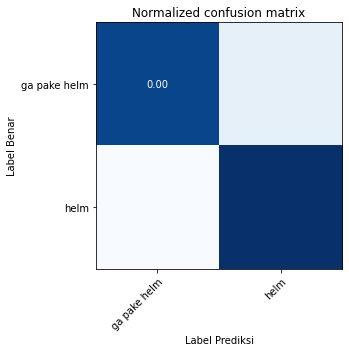

time: 149 ms


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if not title:
    if normalize:
      title = 'Normalized confusion matrix'
    else:
      title = 'Confusion matrix, without normalization'

  #compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  #Only use the labels that appear in the data
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np. newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, withput normalization')

  print(cm)

  fig, ax = plt.subplots(figsize=(5,5))
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  #ax.figure.colorbar(im, ax=ax)
  #we want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         #...and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='Label Benar',
         xlabel='Label Prediksi')
  
  #Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")
  #Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[1, j], fmt),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")
      fig.tight_layout()
      return ax

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

Menyimpan dan Konversi Model ke ".tfllite"

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Deteksi_Helm_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/model/assets
time: 13.8 s


Menyimpan model tflite versi kompatibel quantized

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('Deteksi_Helm_MobileNet_Quantized.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets


INFO:tensorflow:Assets written to: save/model/assets


time: 14.9 s


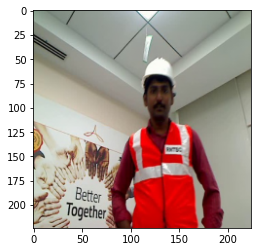

Label yang benar adalah: 1 : helm
Nilai yang diprediksi adalah: [1.2e-04 1.0e+00]
Label yang diprediksi adalah: 1 : helm
Prediksi benar
time: 204 ms


In [ ]:
n = 12 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")